## Import Libraries 

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read Points

In [23]:
def read_points():
    with open('Points.txt', 'r') as f:
        points = []
        for line in f.readlines()[1:]:
            points.append(list(map(float, line.strip("\n").split(" "))))
        
    return np.array(points)

In [24]:
points = read_points()
points.shape

(524, 2)

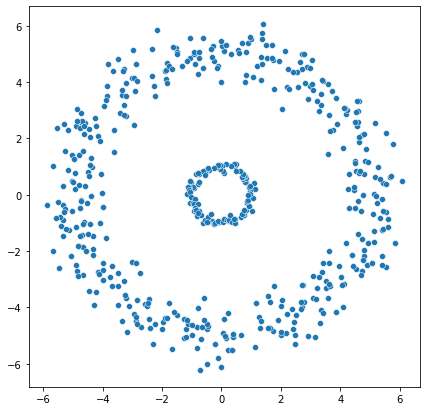

In [25]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=points[:, 0], y=points[:, 1]);

## K-Means

- function `get_random_centroids` is responsible for select some centroids randomly from `X`
- function `check_stop` checks convergence
- function `get_labels`: based on `centroids` it labels `X`
- function `get_centroids`: based on `X` and their `labels`, it outputs the new `centroids`
- function `single_run`: is just a single iteration of K-Means (Random Centroids - Continue till centroids convergence)
- In function `fit`, I run `single_run` for `run_count` times. I pick the best from them (based on `SSE`)

In [26]:
class KMeans:
    def __init__(self, cluster_count, max_iteration, run_count):
        self.k = cluster_count
        self.max_iter = max_iteration
        self.run_count = run_count
        self.centroids = None
    
    def get_random_centroids(self, x):
        return x[np.random.randint(len(x), size=self.k), :]

    def check_stop(self, old_centroids, centroids, iterations):
        return iterations > self.max_iter or (old_centroids == centroids).all()
    
    def get_distance(self, x, y):
        return np.linalg.norm(x-y)
    
    def get_labels(self, x_arr, centroids):
        return np.array([np.argmin(np.array([self.get_distance(x, centroids[i]) for i in range(self.k)])) for x in x_arr])

    def get_centroids(self, x_arr, labels):
        new_centroids, new_centroids_cnt = np.zeros((self.k, x_arr[0].shape[0])), np.zeros(self.k)
        for x_i in range(len(x_arr)):
            new_centroids[labels[x_i]] += x_arr[x_i].flatten()
            new_centroids_cnt[labels[x_i]] += 1
            
        return new_centroids / new_centroids_cnt[:, None]

    def single_run(self, x):
        centroids = self.get_random_centroids(x)
        old_centroids = None
        iter_count = 0
        while not self.check_stop(old_centroids, centroids, iter_count):
            old_centroids = centroids
            centroids = self.get_centroids(x, self.get_labels(x, centroids))
            iter_count += 1
        
        return centroids
    
    def fit(self, x):
        centroids_arr = [self.single_run(x) for _ in range(self.run_count)]
        self.centroids = centroids_arr[np.argmin(np.array([self.SSE(x, c) for c in centroids_arr]))]
        
        return self.get_labels(x, self.centroids)
            
    def SSE(self, x, centroids):
        labels = self.get_labels(x, centroids)
        
        return sum([np.linalg.norm(x[i]-centroids[labels[i]])**2 for i in range(len(x))])

In [34]:
labels1 = KMeans(cluster_count=2, max_iteration=np.inf, run_count=1).fit(points)
labels2 = KMeans(cluster_count=2, max_iteration=np.inf, run_count=1).fit(points)

I set `run_count` to 1. Cause I thought that maybe you want us to get two different clusterings! (setting it to higher numbers will lower this probability)

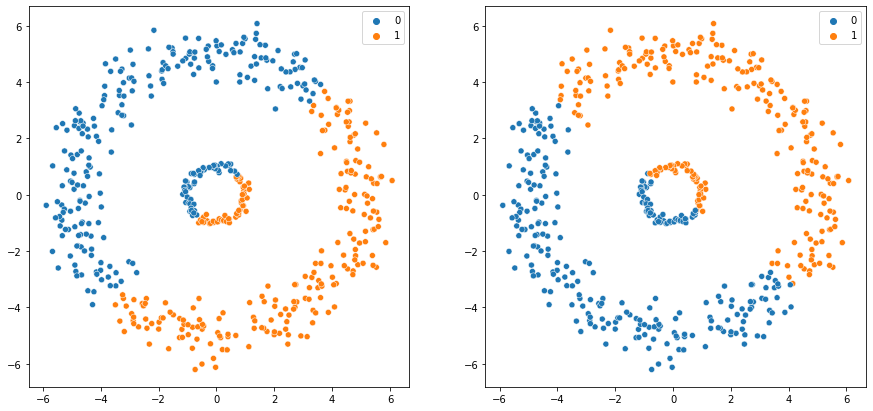

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sns.scatterplot(x=points[:, 0], y=points[:, 1], hue=labels1, ax=axs[0]);
sns.scatterplot(x=points[:, 0], y=points[:, 1], hue=labels2, ax=axs[1]);

We see that it cannot cluster them properly. If we think about it, it totaly makes sense. We want the outer part to be in one cluster and the inside ones on another. In this space, the mean of the outer cluster is the same as the mean of inside ones. So...

## Change Space

We can easily another dimension to our points which is $x^2 + y^2$. This will help us to cluster these points accurately.

In [29]:
new_points = np.zeros((points.shape[0], 3))
new_points[:, :2] = points
new_points[:, 2] = new_points[:, 0] ** 2 + new_points[:, 1] ** 2

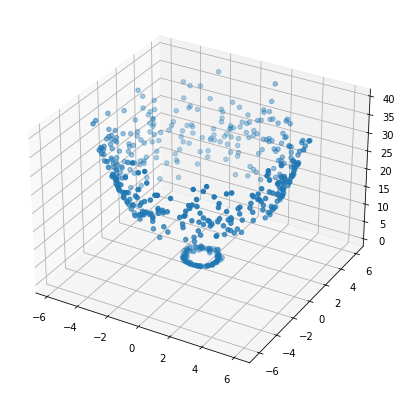

In [36]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')
ax.scatter(new_points[:, 0], new_points[:, 1], new_points[:, 2]);

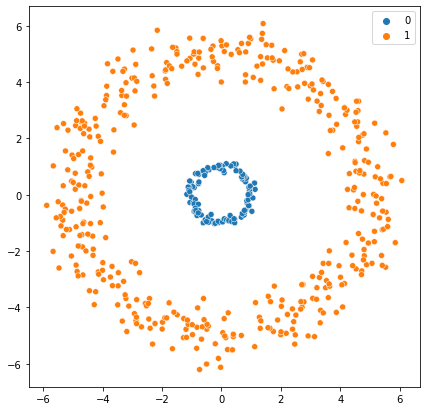

In [37]:
labels = KMeans(cluster_count=2, max_iteration=np.inf, run_count=5).fit(new_points)
plt.figure(figsize=(7, 7))
sns.scatterplot(x=points[:, 0], y=points[:, 1], hue=labels);